In [3]:
with open('list_landmarks_align_celeba.txt') as f:
    for idx, line in enumerate(f):
        print(line)
        if  idx == 3:
            break

202599

lefteye_x lefteye_y righteye_x righteye_y nose_x nose_y leftmouth_x leftmouth_y rightmouth_x rightmouth_y

000001.jpg 69  109  106  113   77  142   73  152  108  154

000002.jpg 69  110  107  112   81  135   70  151  108  153



In [68]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import torchvision

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A # augmentation
from albumentations.pytorch import ToTensorV2

In [5]:
image = cv2.imread('./img_align_celeba/000002.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

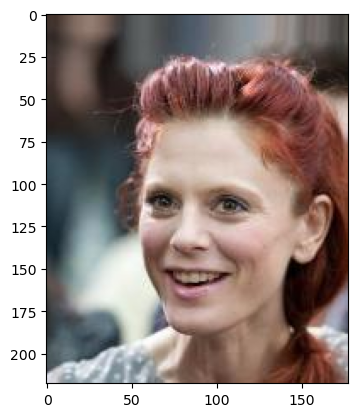

In [6]:
plt.imshow(image)

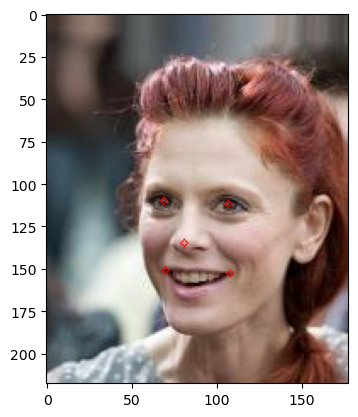

In [7]:
cv2.circle(image, (69, 110), 2, (255, 0, 0))
cv2.circle(image, (107, 112), 2, (255, 0, 0))
cv2.circle(image, (81, 135), 2, (255, 0, 0))
cv2.circle(image, (70, 151), 2, (255, 0, 0))
cv2.circle(image, (108, 153), 2, (255, 0, 0))
plt.imshow(image)

In [8]:
image.shape

(218, 178, 3)

In [9]:
train_transform = A.Compose([
     A.ShiftScaleRotate(shift_limit=.1, 
                        scale_limit=.1,
                        rotate_limit=20,
                        p=1.),
     A.HorizontalFlip(p=0.5),
     A.Normalize(),
     ToTensorV2()
     ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
)
test_transform = A.Compose([
     A.Normalize(),
     ToTensorV2()
     ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False),
)

c:\Software\miniconda3\envs\rl\lib\site-packages\albumentations\core\composition.py:151: UserWarning: Got processor for keypoints, but no transform to process it.
  warnings.warn(f"Got processor for {proc.default_data_name}, but no transform to process it.")


In [29]:
class Celeba(Dataset):
    def __init__(self, indices, transform):
        self.indices = indices
        self.transform = transform
        self.targets = {}
        with open('list_landmarks_align_celeba.txt') as f:
            for idx, line in tqdm(enumerate(f)):
                if idx < 2:
                    continue
                line_splitted = line.split()
                key_points = [int(el) for el in line_splitted[1:]]
                key_points = np.array(key_points).reshape(5, 2)
                self.targets[int(line_splitted[0][:6])] = key_points

    def __getitem__(self, index): # []
        image_index = self.indices[index]
        image = cv2.imread('./img_align_celeba/' + str(image_index).zfill(6) + '.jpg')
        target = self.targets[image_index]
        transformed = self.transform(image=image, keypoints=target)
        return transformed['image'], torch.tensor(transformed['keypoints']).reshape(-1)

    def __len__(self):
        return len(self.indices)

In [40]:
train_dataset = Celeba(range(1, 1000), train_transform)
test_dataset = Celeba(range(1000, 1200), test_transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

202601it [00:00, 233171.62it/s]
202601it [00:00, 249595.60it/s]


In [41]:
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
for x,y in train_dataloader:
    break

image = x[0].permute(1, 2, 0)
image = image * torch.tensor(std)[None, None, ...] + torch.tensor(mean)[None, None, ...]
image = (image.numpy() * 255).astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for el in y[0]:
    cv2.circle(image, el.tolist(), 2, (255, 0, 0))
plt.imshow(image)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Input argument doesn't provide sequence protocol
>  - Can't parse 'center'. Input argument doesn't provide sequence protocol


In [52]:
# class Net(torch.nn.Module):
#     def init(self):
#         super(Net).init()
#         self.act = torch.nn.ReLU()
#         self.maxpool = torch.nn.MaxPool2d(2)
#         self.conv1 = torch.nn.Conv2d(3, 16, 3)
#         self.conv2 = torch.nn.Conv2d(16, 16, 3)
#         self.conv3 = torch.nn.Conv2d(16, 16, 3)

#     # self.linear1 = nn.Linear()

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.act(x)
#         x = self.maxpool(x)
#         x = self.conv2(x)
#         x = self.act(x)
#         x = self.maxpool(x)
#         x = self.conv3(x)
#         x = self.act(x)
#         x = self.maxpool(x)
#         return x

In [42]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [55]:
class Net(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.act = torch.nn.ReLU()
        self.batch_norm_2d = torch.nn.BatchNorm2d(8)
        self.batch_norm_1d = torch.nn.BatchNorm1d(25*20*8)

        self.conv1 = torch.nn.Conv2d(3, 8, 3)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(8, 8, 3)
        self.conv3 = torch.nn.Conv2d(8, 8, 3)

        self.linear1 = torch.nn.Linear(25*20*8, 10) # find size

    def forward (self, x):
        x = self.conv1(x)
        x = self.batch_norm_2d(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.batch_norm_2d(x)
        x = self.act(x)
        x = self.maxpool(x) 
        x = self.conv3(x)
        x = self.batch_norm_2d(x)
        x = self.act(x)
        x = self.maxpool(x)
        x = x.reshape(-1, 500*8)
        x = self.batch_norm_1d(x)
        x = self.linear1(x)
        return x


In [87]:
model = torchvision.models.efficientnet_b0(torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2, inplace=True),
    torch.nn.Linear(1280, 10)
)
model = model.to(DEVICE)
x = x.to(DEVICE)
model(x).shape

torch.Size([16, 10])

In [77]:
model = Net().to(DEVICE)
x,y = x.to(DEVICE), y.to(DEVICE)
model(x).shape

torch.Size([16, 10])

In [88]:
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [89]:
loss_array = []

for epoch in tqdm(range(10)):
    batch_loss = []
    for x,y in train_dataloader:
        x = x.to(DEVICE) #, y.to(DEVICE)
        # print(type(x))
        optimizer.zero_grad()
        pred = model(x)
        pred_loss = loss(pred, y.to(DEVICE).to(torch.float32))
        pred_loss.backward()
        optimizer.step()
        batch_loss.append(pred_loss.item())
    loss_array.append(np.mean(batch_loss))

100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


In [90]:
loss_array

[9300.509099082341,
 3018.266789512029,
 871.779523577009,
 334.85571337503103,
 250.59624614412823,
 237.7752402169364,
 233.23498268732948,
 232.30890280102926,
 228.162593781002,
 227.84204658629403]

In [91]:
np.mean(loss_array)

1493.5331137763128